## Retail Store Sales Forecasting with Neural Networks - LSTM
## By Yasaman Ensafi - 500913843
### Ryerson Data Science and Analytics (MSc)
#### 2019

## Import libraries

In [65]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
import itertools
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series

## Load Dataset

In [66]:
data= pd.read_excel('Sample_Superstore.xls')

## Edit columns names

In [67]:
# Lower case column names
data.columns = map(str.lower, data.columns)

#Replace spaces with '_'
data.columns = data.columns.str.replace(" ", "_")
data.columns = data.columns.str.replace("-", "_")
data.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

## Separate dataframe of each category

In [68]:
furniture=data.loc[data['category'] == 'Furniture']

technology=data.loc[data['category'] == 'Technology']
office=data.loc[data['category'] == 'Office Supplies']

## Aggregating sales by date

In [69]:
furniture= furniture.groupby('order_date')['sales'].sum().reset_index()

technology= technology.groupby('order_date')['sales'].sum().reset_index()
office= office.groupby('order_date')['sales'].sum().reset_index()

In [70]:
#Set index 
furniture = furniture.set_index('order_date')

technology = technology.set_index('order_date')
office = office.set_index('order_date')

In [71]:
#furniture['sales']

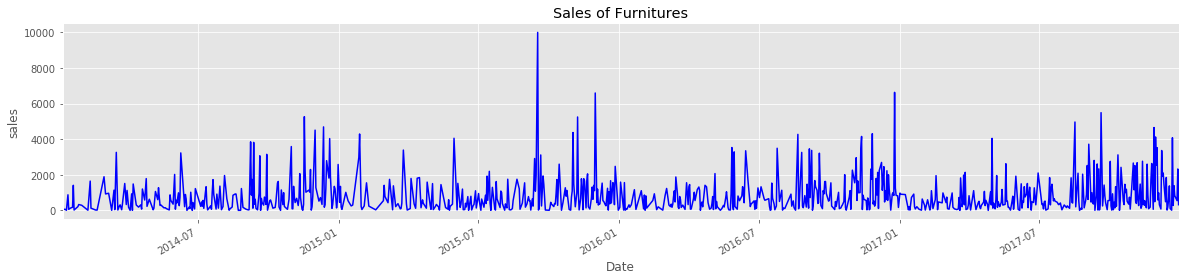

In [72]:
ax= furniture['sales'].plot(color='blue',figsize=(20,4))
ax.set_xlabel("Date")
ax.set_ylabel('sales')
ax.set_title("Sales of Furnitures")
plt.show()

In [73]:
# Using averages daily sales value - set start of the month as index
df = furniture['sales'].resample('MS').mean()
#df= avg_furniture_sales
#avg_technology_sales = technology_sales['sales'].resample('MS').mean()
#avg_office_sales = office_sales['sales'].resample('MS').mean()

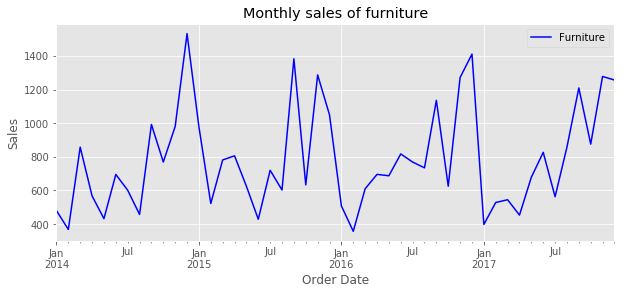

In [74]:
df.plot(figsize=(10, 4),color='blue',label = 'Furniture')

#avg_technology_sales.plot(figsize=(10, 4),color='red',label = 'Technology')

#avg_office_sales.plot(figsize=(10, 4),color='green',label = 'Office Supplies')
plt.xlabel("Order Date")
plt.ylabel('Sales')
plt.title("Monthly sales of furniture")
plt.legend()
plt.show()

In [75]:
X = df.values

In [76]:
# Transform Time Series to Supervised Learning
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df


In [77]:
# Make a differenced series to make time-series stationary
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [78]:
# Transform Time Series to Stationary
raw_values = df.values
diff_values = difference(raw_values, 1)

In [79]:
# Transform Time Series to Supervised Learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [80]:
train_size = int(len(df) * 0.75)
trainset, testset= supervised_values[0:-12], supervised_values[-12:]

In [81]:
# Scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [82]:
#  Invert the scale on forecasts to the original scale
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [83]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(trainset, testset)

In [84]:
# fit an LSTM network to train the data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        #epoch can be changed to 1
        model.fit(X, y, epochs=5, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [91]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 100, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

Epoch 1/5
35/35 [==============================] - 1s 36ms/step - loss: 0.2507
Epoch 2/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2474
Epoch 3/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2445
Epoch 4/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2419
Epoch 5/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2394
Epoch 1/5
35/35 [==============================] - 0s 2ms/step - loss: 0.2369
Epoch 2/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2349
Epoch 3/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2327
Epoch 4/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2306
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.2285
Epoch 1/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2261
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.2244
Epoch 3/5
35/35 [==============================] - 0s 2ms/step 

35/35 [==============================] - 0s 2ms/step - loss: 0.1581
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1705
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1697
Epoch 4/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1692
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1688
Epoch 1/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1583
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1688
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1681
Epoch 4/5
35/35 [==============================] - 0s 3ms/step - loss: 0.1677
Epoch 5/5
35/35 [==============================] - 0s 3ms/step - loss: 0.1674
Epoch 1/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1582
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1672
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1

35/35 [==============================] - 0s 2ms/step - loss: 0.1398
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1527
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1512
Epoch 4/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1511
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1510
Epoch 1/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1391
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1529
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1512
Epoch 4/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1511
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1509
Epoch 1/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1385
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1525
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1

35/35 [==============================] - 0s 2ms/step - loss: 0.1290
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1394
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1396
Epoch 4/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1395
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1394
Epoch 1/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1286
Epoch 2/5
35/35 [==============================] - 0s 3ms/step - loss: 0.1390
Epoch 3/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1391
Epoch 4/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1389
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1388
Epoch 1/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1282
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1384
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1

35/35 [==============================] - 0s 2ms/step - loss: 0.1227
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1312
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1311
Epoch 4/5
35/35 [==============================] - 0s 3ms/step - loss: 0.1310
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1309
Epoch 1/5
35/35 [==============================] - 0s 3ms/step - loss: 0.1225
Epoch 2/5
35/35 [==============================] - 0s 3ms/step - loss: 0.1308
Epoch 3/5
35/35 [==============================] - 0s 3ms/step - loss: 0.1307
Epoch 4/5
35/35 [==============================] - 0s 3ms/step - loss: 0.1307
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1306
Epoch 1/5
35/35 [==============================] - 0s 5ms/step - loss: 0.1223
Epoch 2/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1306
Epoch 3/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1

array([[-0.10527156],
       [ 0.09376666],
       [-0.3169023 ],
       [-0.02426797],
       [ 0.18113038],
       [-0.04413089],
       [ 0.14352766],
       [ 0.30779514],
       [-0.33882472],
       [ 0.08227471],
       [-0.10103539],
       [-0.4797244 ],
       [-0.10431892],
       [ 0.28625533],
       [ 0.03446379],
       [ 0.10296777],
       [ 0.31149027],
       [ 0.46213338],
       [ 0.07189465],
       [ 0.3887203 ],
       [-0.8073211 ],
       [ 0.29055747],
       [-0.44136167],
       [-0.1479182 ],
       [ 0.20212436],
       [ 0.35998115],
       [ 0.07792187],
       [ 0.07880411],
       [ 0.1826173 ],
       [ 0.07008782],
       [ 0.24161848],
       [ 0.31253472],
       [-0.28336126],
       [ 0.4818754 ],
       [-0.48827347]], dtype=float32)

In [92]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]


In [93]:
# walk-forward validation on the test data
predictions_lstm1 = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions_lstm1.append(yhat)
    expected = raw_values[len(train_scaled) + i ]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=979.818077, Expected=1410.719808
Month=2, Predicted=337.318528, Expected=397.602133
Month=3, Predicted=551.237805, Expected=528.179800
Month=4, Predicted=598.554023, Expected=544.672240
Month=5, Predicted=618.334821, Expected=453.297905
Month=6, Predicted=710.455581, Expected=678.302328
Month=7, Predicted=811.268677, Expected=826.460291
Month=8, Predicted=782.667005, Expected=562.524857
Month=9, Predicted=820.975152, Expected=857.881889
Month=10, Predicted=929.822702, Expected=1209.508583
Month=11, Predicted=941.145621, Expected=875.362728
Month=12, Predicted=1099.538553, Expected=1277.817759


In [94]:
len(predictions_lstm1)

12

Test RMSE: 286.687


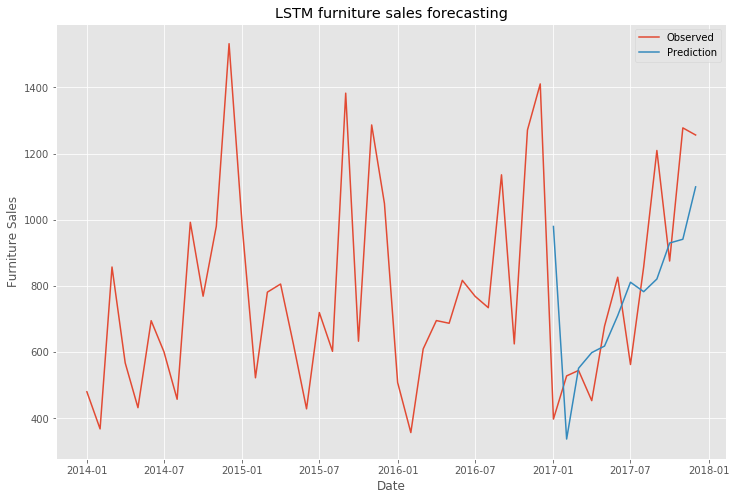

In [95]:
# report performance
rcParams['figure.figsize'] = 12, 8
from math import sqrt
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed")
plt.plot(df[36:].index,predictions_lstm1,label="Prediction")
plt.title('LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [96]:
def performance(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))
performance(raw_values[-12:], predictions_lstm1)

 The MSE of forecasts is 64414.65
 The RMSE of forecasts is 253.8
 The MAPE of forecasts is 30.74


Source: https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/